#####################################################
## 2ο Μέρος : Χαρακτηριστικά Βραχέος Χρόνου Σημάτων Φωνής και Μουσικής 
####################################################

#### Οι Ασκήσεις πραγματοποιήθηκαν από τους : ΒΑΣΙΛΕΙAΔΗΣ ΔΗΜΉΤΡΙΟΣ AM: 03122111/el22111 - ΓΡΗΓΟΡΙΟΣ ΣΤΑΜΑΤΟΠΟΥΛΟΣ ΑΜ: 03122039/el22039.        Η Βιβλιογραφία μας αποτελείται από:
* Το documentation όλων των διαθέσιμων βιβλιοθηκών που αναφέρονται στο αρχείο "PYTHON GUIDE" στη διαδασκαλική ιστοσελίδα του Helios, 
* Όλα τα σετ διαφανειών που είναι ανεβασμένα στην παραπάνω ιστοσελίδα,
* Καθώς και πληροφορίες από δίαφορες άλλες όπως:


    *  https://dsp.stackexchange.com/ , 
    *  https://stackoverflow.com/search?q=jupyter+notebook , 
    *  https://ieeexplore.ieee.org/Xplore/home.jsp , 
    *  https://www.wikipedia.org/ , 
    *  https://arxiv.org/abs/2306.08436 , 
    *  https://sites.google.com/berkeley.edu/ee123-sp20/python , 
    *  https://github.com/openlists/DSPResources και άλλες ...

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as ipd
import scipy.signal as sig

### Βοηθητικές συναρτήσεις Ενέργειας Βραγχέος Χρόνου και Ρυθμού Εναλλαγής Προσήμου

In [7]:
def ste(signal, window_length_samples):
    window = np.hamming(window_length_samples)
    squared_signal = signal ** 2
    ste = np.convolve(squared_signal, window, mode='same')  # Align with input signal
    return ste

In [8]:
def zero_crossing_rate(signal, window_length_samples):
    sgn_x = np.sign(signal)
    diff = sgn_x[1:] - sgn_x[:-1]
    crossings = np.abs(diff) / 2  # 1 for zero-crossing, 0 otherwise
    crossings_padded = np.concatenate([[0], crossings])  # Align with original signal
    window = np.hamming(window_length_samples)
    zcr = np.convolve(crossings_padded, window, mode='same')
    return zcr / window_length_samples  # Normalize to rate per sample

In [9]:
def short_time_energy(x, frame_size, hop_size):
    """
    Υπολογίζει την ενέργεια βραχέος χρόνου του σήματος x[n].
    frame_size, hop_size σε δείγματα.
    Επιστρέφει: (st_energy, frames_t)
    όπου st_energy: πίνακας με την ενέργεια ανά πλαίσιο
          frames_t: οι κεντρικοί χρόνοι (σε δείγματα ή sec) των παραθύρων
    """
    num_frames = 1 + (len(x) - frame_size) // hop_size
    st_energy = np.zeros(num_frames)
    frames_t = np.zeros(num_frames)

    #window = np.ones(frame_size)  # Τετραγωνικό παράθυρο
    window = np.hamming(frame_size)

    for i in range(num_frames):
        start = i * hop_size
        frame = x[start : start + frame_size] * window
        st_energy[i] = np.sum(frame**2)
        frames_t[i] = start + frame_size/2  # κεντρικό δείγμα (για σχεδίαση)

    return st_energy, frames_t


In [10]:
def frames_to_time(frames_idx, sr):
    #Μετατρέπει δείκτες δειγμάτων σε δευτερόλεπτα, δεδομένου του sr.
    return frames_idx / sr

## Ερώτημα 2.1: Φόρτωση και σχεδίαση του σήματος φωνής

In [11]:
speech, sr_speech = sf.read("dsp25_lab1_Data/speech_utterance.wav")  # περιέχει "Oh mother, I saw them"
ipd.Audio(speech, rate=sr_speech)

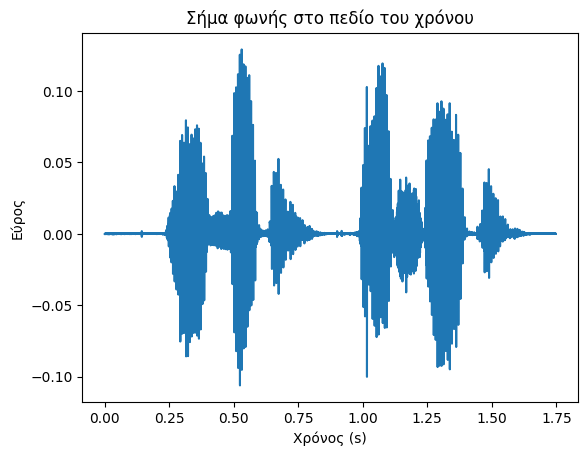

In [12]:
# Σχεδίαση σήματος στο πεδίο του χρόνου
t_axis_speech = np.arange(len(speech)) / sr_speech
plt.figure()
plt.title("Σήμα φωνής στο πεδίο του χρόνου")
plt.plot(t_axis_speech, speech)
plt.xlabel("Χρόνος (s)")
plt.ylabel("Εύρος")
plt.show()

## Ερώτημα 2.2: Ενέργεια βραχέος χρόνου και ρυθμός εναλλαγής προσήμου

In [13]:
# Θέτουμε π.χ. window length 20 ms και hop 10 ms
frame_dur = 0.02  # σε sec
hop_dur = 0.01    # σε sec
frame_size = int(frame_dur * sr_speech)
hop_size = int(hop_dur * sr_speech)

In [14]:
from numpy import size
energy_speech, frames_speech_e = short_time_energy(speech, frame_size, hop_size)
#energy_speech = ste(speech, frame_size)

zcr_speech = librosa.feature.zero_crossing_rate(
    y=speech,
    frame_length=frame_size, # Χρησιμοποιήσαμε τη βιβλιοθήκη της librosa λόγω κάποιων τεχνικών προβλημάτων, 
    hop_length=hop_size,     # η υλοποίηση με συνέλιξη είναι παραπάνω
    center=True
)

zcr_speech = zcr_speech[0] #Πρέπει να κάνουμε το πίνακα μονοδιάστατο
frames_speech_z = np.arange(size(zcr_speech))

# Μετατροπή των κεντρικών δειγμάτων σε δευτερόλεπτα
time_energy = frames_to_time(frames_speech_e, sr_speech)
time_zcr = frames_speech_z * (hop_size / sr_speech)

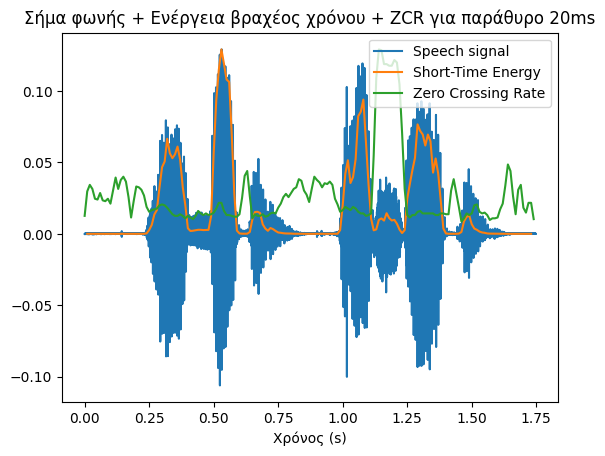

In [15]:
#plots
plt.figure()
plt.title("Σήμα φωνής + Ενέργεια βραχέος χρόνου + ZCR για παράθυρο 20ms")
plt.plot(t_axis_speech, speech, label="Speech signal")
plt.plot(time_energy, energy_speech * np.max(speech) / np.max(energy_speech), label="Short-Time Energy") # Κανονικοποιούμε τα σήματα στο μέγεθος του αρχικού σήματος φωνής
plt.plot(time_zcr, zcr_speech * np.max(speech) / np.max(zcr_speech), label="Zero Crossing Rate")
plt.xlabel("Χρόνος (s)")
plt.legend()
plt.show()

In [16]:
#Για frame length 50 ms και hop 10 ms
frame_dur = 0.05  # σε sec
hop_dur = 0.01   # σε sec
frame_size = int(frame_dur * sr_speech)
hop_size = int(hop_dur * sr_speech)

In [17]:
energy_speech, frames_speech_e = short_time_energy(speech, frame_size, hop_size)
zcr_speech = librosa.feature.zero_crossing_rate(
    y=speech,
    frame_length=frame_size,
    hop_length=hop_size,
    center=True
)
# zcr_speech_arr.shape = (1, num_frames)
zcr_speech = zcr_speech[0] #Πρέπει να κάνουμε το πίνακα μονοδιάστατο
frames_speech_z = np.arange(len(zcr_speech))
# Μετατροπή των κεντρικών δειγμάτων σε δευτερόλεπτα
time_energy = frames_to_time(frames_speech_e, sr_speech)
time_zcr = frames_speech_z * (hop_size / sr_speech)

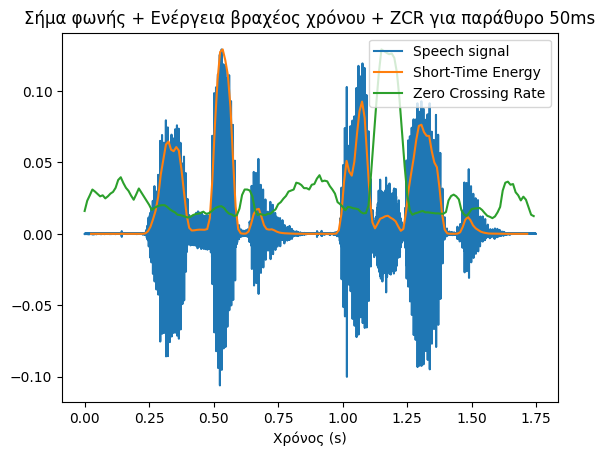

In [18]:
#plots
plt.figure()
plt.title("Σήμα φωνής + Ενέργεια βραχέος χρόνου + ZCR για παράθυρο 50ms")
plt.plot(t_axis_speech, speech, label="Speech signal")
plt.plot(time_energy, energy_speech * np.max(speech) / np.max(energy_speech), label="Short-Time Energy")
plt.plot(time_zcr, zcr_speech * np.max(speech) / np.max(zcr_speech), label="Zero Crossing Rate")
plt.xlabel("Χρόνος (s)")
plt.legend()
plt.show()

Στα παραπάνω διαγράμματα, η ενέργεια βραχέος χρόνου του σήματος ομιλίας παρουσιάζει υψηλές τιμές στα τμήματα όπου η φωνή είναι δυνατότερη (π.χ. φωνήεντα ή τονισμένες συλλαβές) και χαμηλές τιμές κατά τις παύσεις ή τα άηχα σύμφωνα ενώ ο ρυθμός εναλλαγής προσήμου (ZCR) είναι μικρός σε ηχηρά/φωνηεντικά τμήματα (όπου το σήμα είναι πιο ημιτονικό και διατηρεί το πρόσημό του για μεγαλύτερα διαστήματα) και αυξάνεται σε άηχα τμήματα ή θορύβους (όπου το σήμα αλλάζει πιο συχνά πρόσημο).

Επιπλέον, παρατηρούμε πως τα αποτελέσματα των γραφικών παραστάσεων είναι πιο "αιχμηρά" για παράθυρα μικρότερου μεγέθους, καθώς έχουμε περισσότερα δείγματα μικρότερου μεγέθους

## Ερώτημα 2.3: Υπολογισμός STFT (log φασματογράφημα)+ Φασματικό κέντρο (SC), Φασματική ροή (SF)

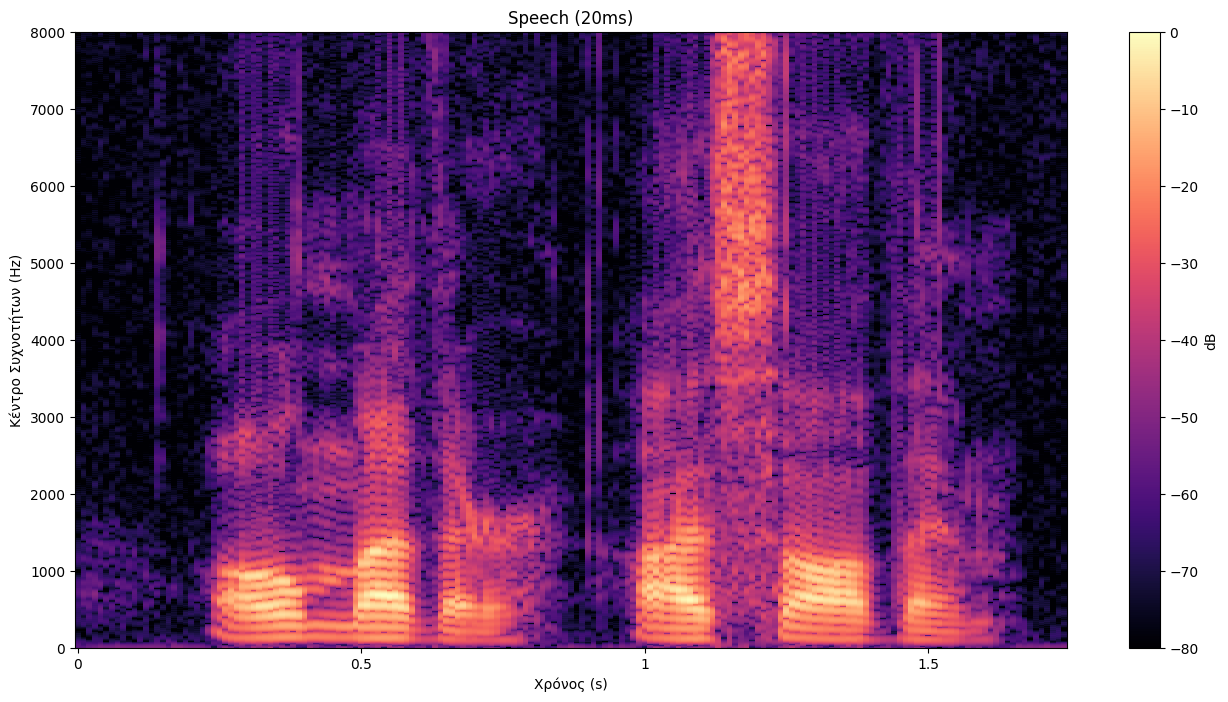

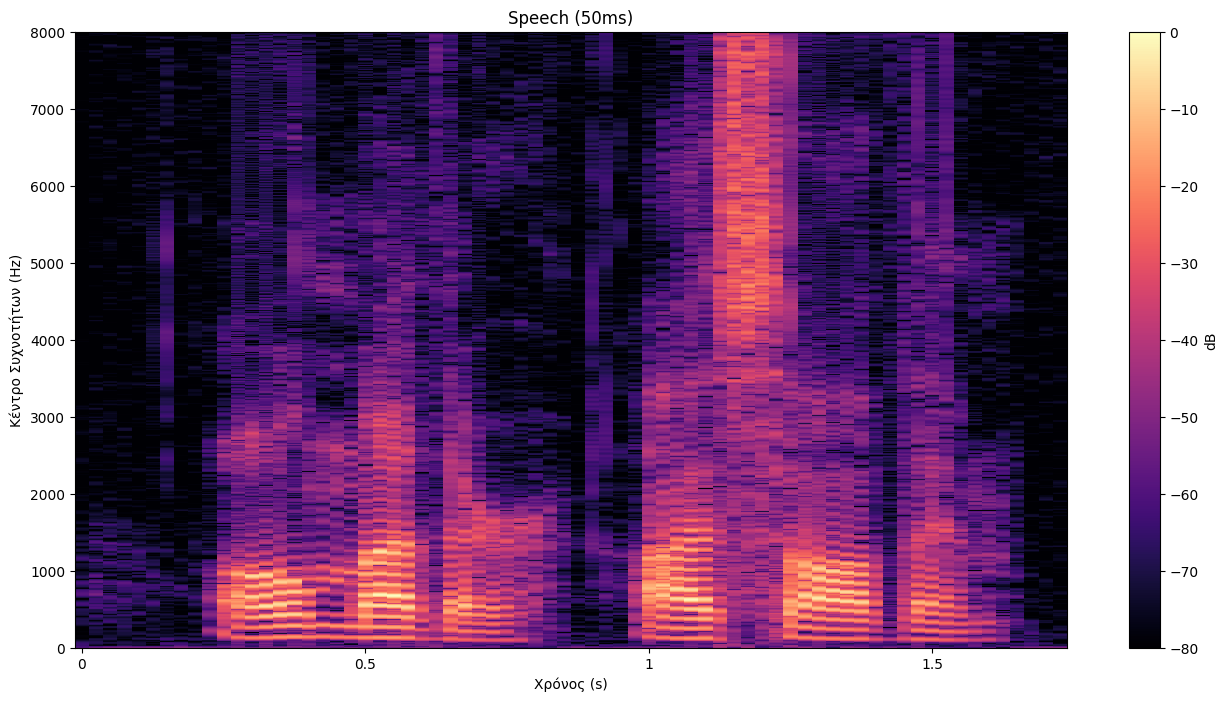

In [19]:
# Συνάρτηση για υπολογισμό STFT και επιστροφή φάσματος σε dB
def compute_spectrogram(signal, fs, frame_duration, n_fft=sr_speech, hop_fraction=0.5):
    frame_len = int(frame_duration * fs)
    hop_len = int(frame_len * hop_fraction)
    window = np.hamming(frame_len)
    # Υπολογισμός STFT (complex array)
    # Η παράμετρος center=True στην κλήση της librosa.stft εξασφαλίζει ότι το σήμα πακεταρίζεται 
    # με μηδενικά ώστε το παράθυρο να κεντραριστεί γύρω από κάθε σημείο
    stft_matrix = librosa.stft(signal, n_fft=n_fft, hop_length=hop_len, win_length=frame_len, window='hamming', center=True) 
    # Μέτρο (απόλυτο) και μετατροπή σε dB
    spectrogram = np.abs(stft_matrix+0.0001)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram_db, frame_len, hop_len

# Υπολογισμός φασματογραμμάτων για speech (20ms και 50ms)
spec_speech_20, flen_s20, hop_s20 = compute_spectrogram(speech, sr_speech, 0.02)
spec_speech_50, flen_s50, hop_s50 = compute_spectrogram(speech, sr_speech, 0.05)

#Παρουσίαση για παράθυρα μήκους 20 ms
plt.figure(figsize=(16, 8))
plt.title("Speech (20ms)")
librosa.display.specshow(spec_speech_20, sr=sr_speech, hop_length=hop_s20, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.show()

#Παρουσίαση για παράθυρα μήκους 50 ms
plt.figure(figsize=(16, 8))
plt.title("Speech (50ms)")
librosa.display.specshow(spec_speech_50, sr=sr_speech, hop_length=hop_s50, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.show()



Στα παραπάνω φασματογραφήματα (ενέργεια συχνοτήτων ως προς τον χρόνο), παρατηρούμε τη φασματική δομή του φωνητικού σήματος. Οι σκοτεινότερες περιοχές αντιστοιχούν σε υψηλότερη ένταση σε συγκεκριμένες συχνότητες. Διακρίνονται οριζόντιες ζώνες έντονης ενέργειας στις χαμηλότερες συχνότητες, που αντιστοιχούν στις φορμάντες των φωνηέντων. Αντίθετα, στα σημεία με σύμφωνα όπως τα /s/ ή /sh/, η ενέργεια μετατοπίζεται προς υψηλότερες συχνότητες (πιο φωτεινές περιοχές στα υψηλά Hz).

#### Υπολογισμός  φασματικού κέντρου και της φασματικής ροής μέσω stft

In [20]:
# Συνάρτηση για υπολογισμό STFT, φασματικού κέντρου (με τη βιβλιοθήκη) και φασματικής ροής (custom)
def compute_features(signal, fs, frame_duration, n_fft=2048, hop_fraction=0.5):
    frame_len = int(frame_duration * fs)
    hop_len = int(frame_len * hop_fraction)
    # Υπολογισμός STFT
    stft_matrix = librosa.stft(signal, n_fft=n_fft, hop_length=hop_len,
                                 win_length=min(frame_len, n_fft), window='hamming', center=True)
    
    # Υπολογισμός φασματικού κέντρου με τη συνάρτηση της librosa
    sc = librosa.feature.spectral_centroid(S=np.abs(stft_matrix + 0.0001), sr=fs)
    # Το αποτέλεσμα sc έχει διαστάσεις (1, n_frames); μετατρέπουμε σε 1D vector
    sc = sc.flatten()
    
    # Υπολογισμός φασματικής ροής (spectral flux) από το μέτρο του STFT
    magnitude = np.abs(stft_matrix+0.0001)
    # Υπολογισμός διαφορών μεταξύ διαδοχικών πλαισίων
    S_norm = magnitude / np.sum(magnitude, axis=0, keepdims=True)  # shape (freq_bins, frames)

    flux = []
    for m in range(1, S_norm.shape[1]):
        diff = S_norm[:, m] - S_norm[:, m-1]
        flux_val = np.sum(diff**2)  # L2 norm των διαφορών
        flux.append(flux_val)
    flux = np.concatenate([[0], flux])
    
    return stft_matrix, sc, np.array(flux), frame_len, hop_len

In [21]:
spec_speech20, sc_speech20, flux_speech20, frame_len_20, hop_20 = compute_features(speech, sr_speech, frame_duration=0.02)
spec_speech50, sc_speech50, flux_speech50, frame_len_50, hop_50 = compute_features(speech, sr_speech, frame_duration=0.05)

In [22]:
times_speech20 = librosa.frames_to_time(range(sc_speech20.shape[0]), sr=sr_speech, hop_length = hop_20)
#times_speech20 = np.arange(sc_speech20.shape[0]) * hop_20 / sr_speech
#times_speech50 = np.arange(sc_speech50.shape[0]) * hop_50 / sr_speech
times_speech50 = librosa.frames_to_time(range(sc_speech50.shape[0]), sr=sr_speech, hop_length = hop_50)

Παρουσιάζουμε τα Spectral Centroid και Spectral Flux για διαφορετικά μήκη παραθύρων (20 και 50 ms)

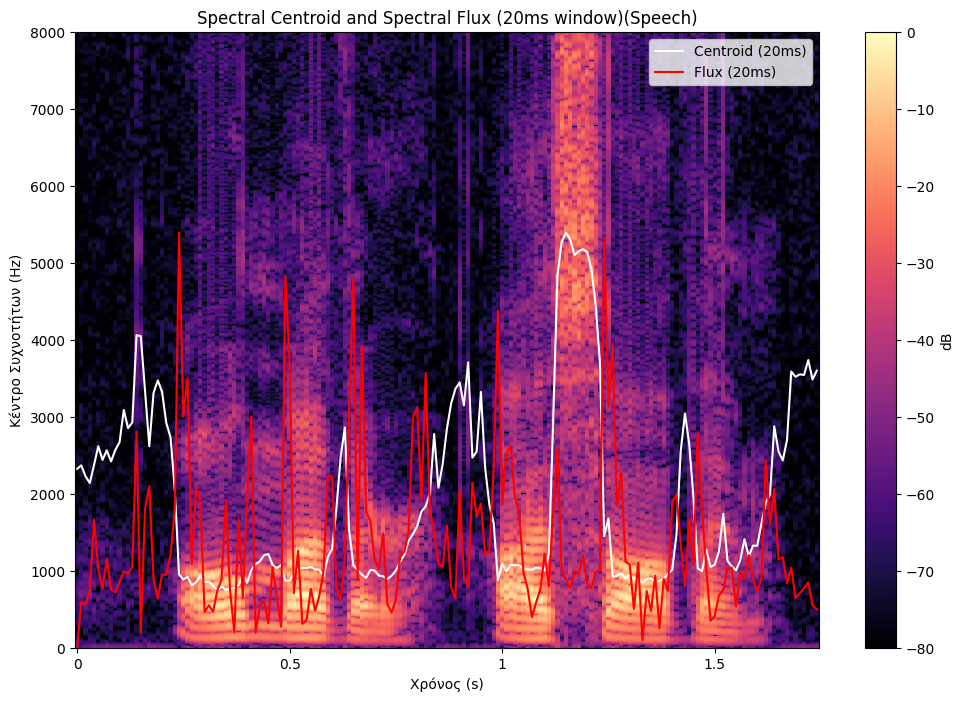

In [23]:
#Παρουσίαση για παράθυρo μήκους 20 ms
plt.figure(figsize=(12, 8))
plt.title("Spectral Centroid and Spectral Flux (20ms window)(Speech)")
librosa.display.specshow(spec_speech_20, sr=sr_speech, hop_length=hop_s20, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.plot(times_speech20, sc_speech20 , label="Centroid (20ms)", color='w')
plt.plot(times_speech20, flux_speech20 * np.max(sc_speech20) / np.max(flux_speech20), label="Flux (20ms)", color='r')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.legend(loc='upper right')
plt.show()

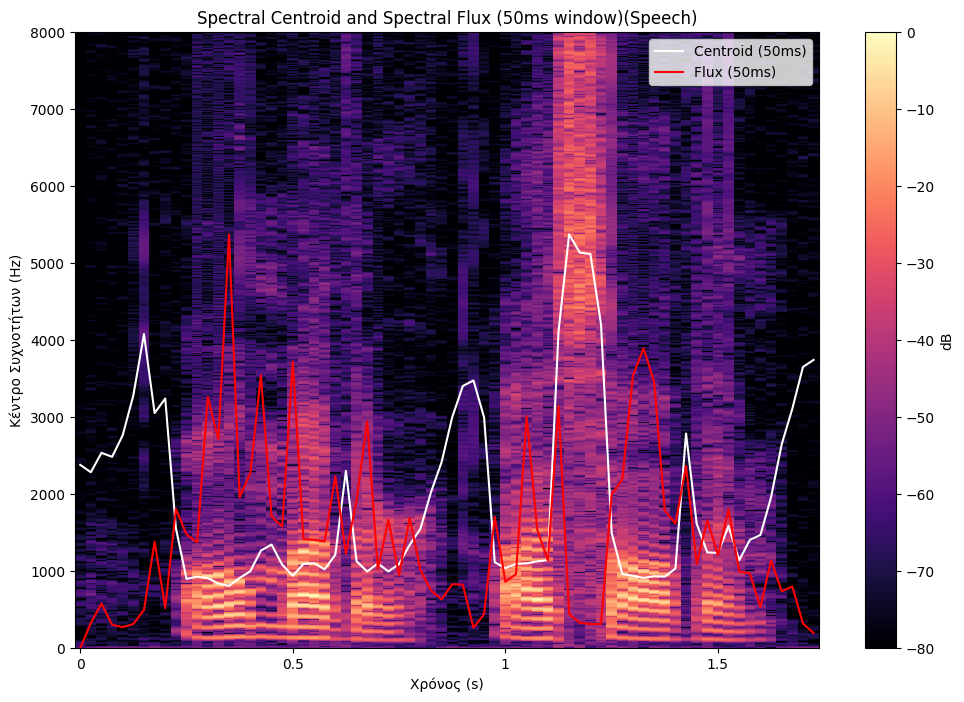

In [24]:
#Παρουσίαση για παράθυρα μήκους 50 ms
plt.figure(figsize=(12, 8))
plt.title("Spectral Centroid and Spectral Flux (50ms window)(Speech)")
librosa.display.specshow(spec_speech_50, sr=sr_speech, hop_length=hop_s50, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.plot(times_speech50, sc_speech50 , label="Centroid (50ms)", color='w')
plt.plot(times_speech50, flux_speech50 * np.max(sc_speech50) / np.max(flux_speech50), label="Flux (50ms)", color='r')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.legend(loc='upper right')
plt.show()

Συμπεράσματα - Παρατηρήσεις:
* Για το φασματικό κέντρο βάρους του σήματος ομιλίας: Παρατηρούμε ότι στις περιοχές όπου κυριαρχούν χαμηλές συχνότητες (π.χ. φωνήεντα με χαμηλό τόνο), το κέντρο βάρους βρίσκεται χαμηλότερα (π.χ. κάτω από 1000 Hz). Αντίθετα, όταν εμφανίζονται ήχοι με περισσότερη υψηλή συχνότητα (όπως τα σφυρίγματα /sh/), το φασματικό κέντρο ανεβαίνει σημαντικά, αντανακλώντας την "φωτεινότητα" του ήχου.
* Για τη φασματική ροή, δηλαδή ο ρυθμός μεταβολής του φάσματος: Παρατηρούμε ακίδες στη φασματική ροή αντιστοιχούν σε απότομες αλλαγές στο φάσμα.Για παράδειγμα, στα όρια μεταξύ φθόγγων (όπου αλλάζει από φωνήεν σε σύμφωνο ή σιωπή) εμφανίζονται υψηλές τιμές spectral flux, υποδεικνύοντας μια ηχητική μετάβαση ή έναρξη νέου ήχου
* Τέλος, τα γραφήματα του παραθύρου 20ms παραμένουν πιο "αιχμηρά" και αναλυτικά.

## Άσκηση 2.4: Επανάληψη Ερωτημάτων 1-3 για σήμα μουσικής

### 2.1: Απεικόνιση στο πεδίο του χρόνου

In [25]:
music, sr_music = sf.read("dsp25_lab1_Data/music.wav")  # περιέχει "Oh mother, I saw them"
ipd.Audio(music, rate=sr_music)


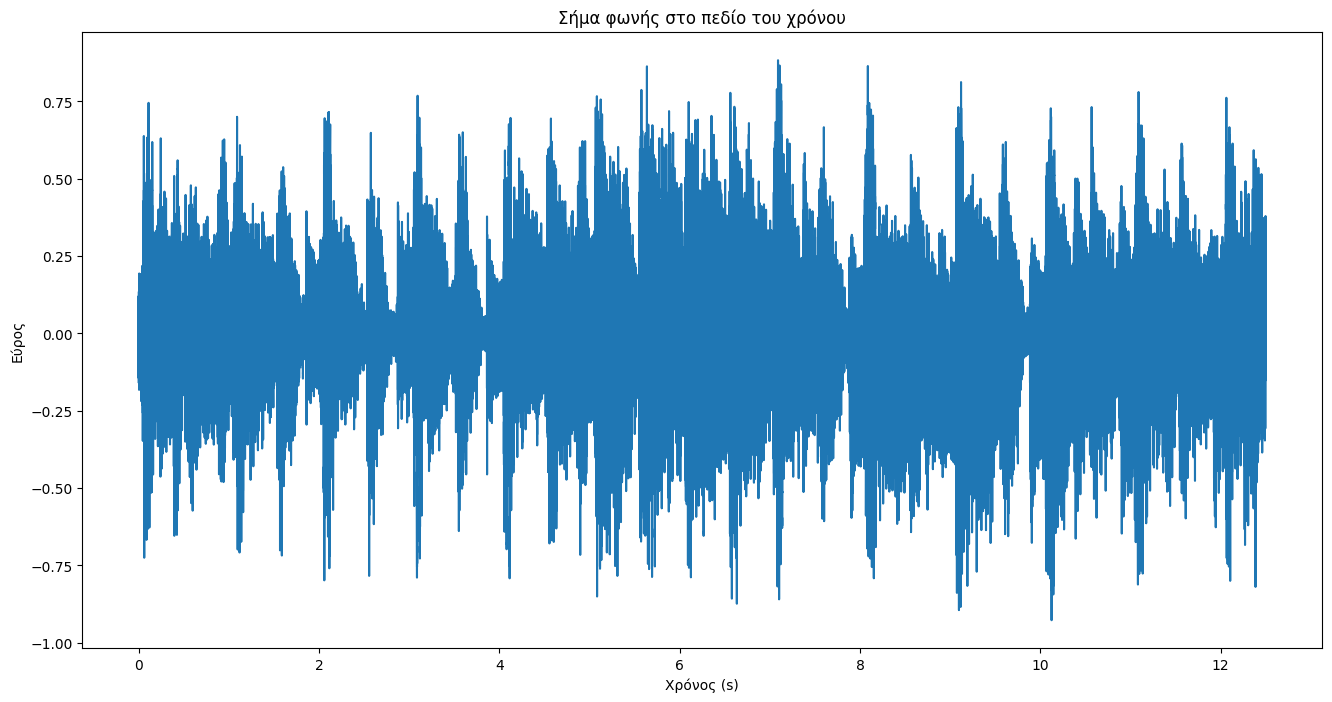

In [26]:
# Σχεδίαση σήματος στο πεδίο του χρόνου
t_axis_music = np.arange(len(music)) / sr_music
plt.figure(figsize=(16, 8))
plt.title("Σήμα φωνής στο πεδίο του χρόνου")
plt.plot(t_axis_music, music)
plt.xlabel("Χρόνος (s)")
plt.ylabel("Εύρος")
plt.show()

Παρατηρούμε το διάγραμμα του σήματος στο πεδίο του χρόνου. Παρουσιάζει διαφορετική μορφή από εκείνη της ομιλίας. Βλέπουμε ένα πιο συνεχές και περιοδικό σήμα, καθώς περιέχει συνεχές νότες και σταθερό ρυθμό

### 2.2: Ενέργεια βραχέος χρόνου και ρυθμός εναλλαγής προσήμου

In [27]:
#######################
#ΓΙΑ ΠΑΡΑΘΥΡΟ 20ms#####
#######################

frame_dur = 0.02  # σε sec
hop_dur = 0.01    # σε sec
frame_size20 = int(frame_dur * sr_music)
hop_size20 = int(hop_dur * sr_music)

energy_music20, frames_music_e20 = short_time_energy(music, frame_size20, hop_size20)
zcr_music20 = librosa.feature.zero_crossing_rate(
    y=music,
    frame_length=frame_size20,
    hop_length=hop_size20,
    center=True #Zero Padding
)
# zcr_music_arr.shape = (1, num_frames)
zcr_music20 = zcr_music20[0] #Πρέπει να κάνουμε το πίνακα μονοδιάστατο
frames_music_z20 = np.arange(len(zcr_music20))

# Μετατροπή των κεντρικών δειγμάτων σε δευτερόλεπτα
time_energy20 = frames_to_time(frames_music_e20, sr_music)
time_zcr20 = frames_music_z20 * (hop_size20 / sr_music)

#######################
#ΓΙΑ ΠΑΡΑΘΥΡΟ 50ms#####
#######################

frame_dur = 0.05  # σε sec
hop_dur = 0.025    # σε sec
frame_size50 = int(frame_dur * sr_music)
hop_size50 = int(hop_dur * sr_music)

energy_music50, frames_music_e50 = short_time_energy(music, frame_size50, hop_size50)
zcr_music50 = librosa.feature.zero_crossing_rate(
    y=music,
    frame_length=frame_size50,
    hop_length=hop_size50,
    center=True #Zero padding
)
# zcr_music_arr.shape = (1, num_frames)

zcr_music50 = zcr_music50[0] #Πρέπει να κάνουμε το πίνακα μονοδιάστατο
frames_music_z50 = np.arange(len(zcr_music50))
# Μετατροπή των κεντρικών δειγμάτων σε δευτερόλεπτα
time_energy50 = frames_to_time(frames_music_e50, sr_music)
time_zcr50 = frames_music_z50 * (hop_size50 / sr_music)

#### PLOTS ΓΙΑ ΤΟ ΕΡΩΤΗΜΑ 2

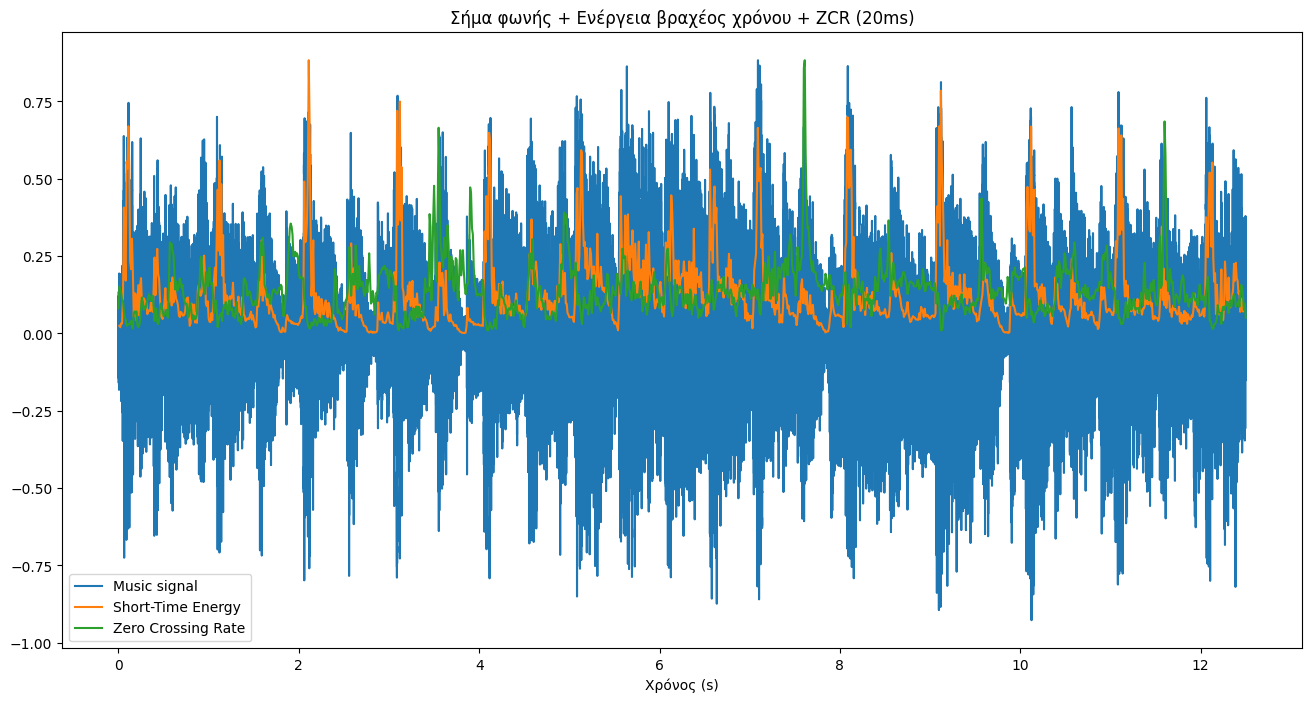

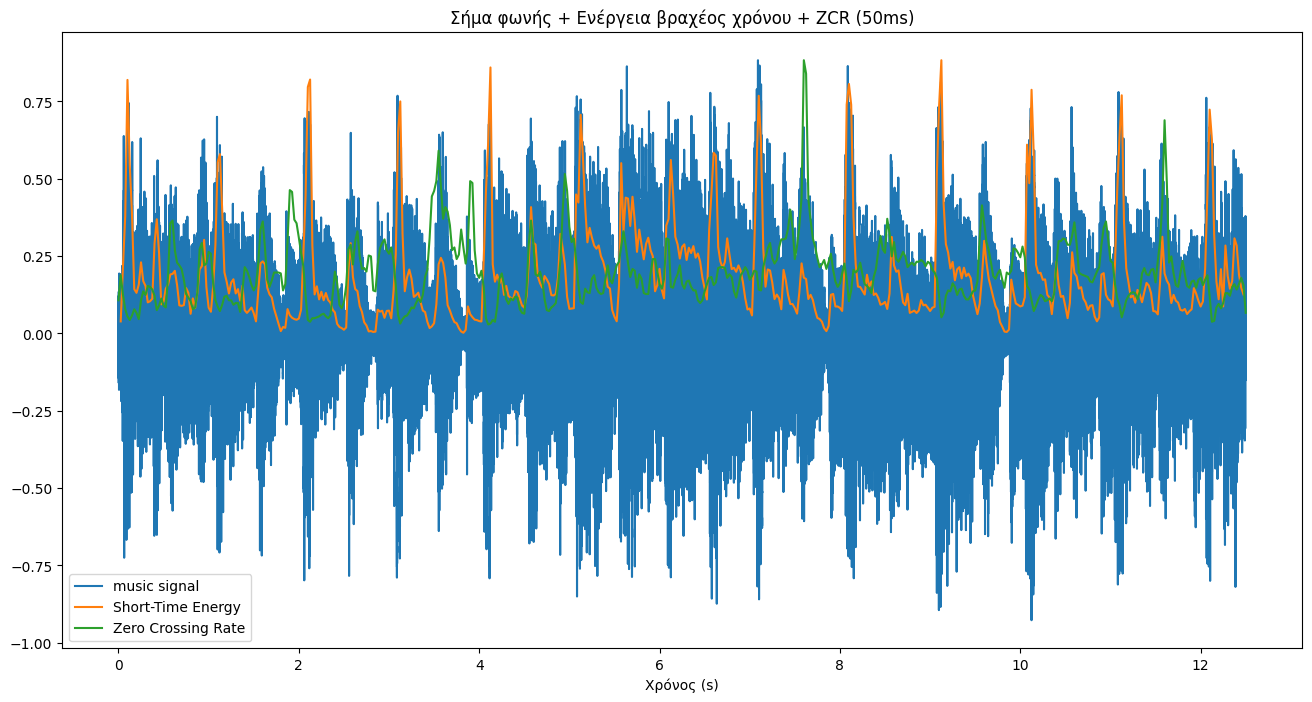

In [28]:
#plots
plt.figure(figsize=(16, 8))
plt.title("Σήμα φωνής + Ενέργεια βραχέος χρόνου + ZCR (20ms)")
plt.plot(t_axis_music, music, label="Music signal")
plt.plot(time_energy20, energy_music20 * np.max(music) / np.max(energy_music20), label="Short-Time Energy")
plt.plot(time_zcr20, zcr_music20 * np.max(music) / np.max(zcr_music20), label="Zero Crossing Rate")
plt.xlabel("Χρόνος (s)")
plt.legend()
plt.show()

#plots
plt.figure(figsize=(16, 8))
plt.title("Σήμα φωνής + Ενέργεια βραχέος χρόνου + ZCR (50ms)")
plt.plot(t_axis_music, music, label="music signal")
plt.plot(time_energy50, energy_music50 * np.max(music) / np.max(energy_music50), label="Short-Time Energy")
plt.plot(time_zcr50, zcr_music50 * np.max(music) / np.max(zcr_music50), label="Zero Crossing Rate")
plt.xlabel("Χρόνος (s)")
plt.legend()
plt.show()

Από τα διαγράμματα ενέργειας βραχέος χρόνου + ZCR, έχουμε τα εξής συμπεράσματα/παρατηρήσεις:
* Η ενέργεια βραχέος χρόνου παρουσιάζει μια πιο τακτική εναλλαγή ανάλογα με τον ρυθμό της μουσικής. Στο μουσικό απόσπασμα με σταθερό ρυθμό, παρατηρούμε πως οι κορυφές της ενέργειας επαναλαμβάνονται περιοδικά.
* Ο ρυθμός εναλλαγής προσήμου τείνει να εξαρτάται από το είδος των οργάνων: ένα τονικό μουσικό όργανο (π.χ. έγχορδο) παράγει κυματομορφές με χαμηλό ZCR, ενώ τα κρουστά όργανα αυξάνουν το ZCR.

### Ερώτημα 2.3: Υπολογισμός STFT (log φασματογράφημα)+ Φασματικό κέντρο (SC), Φασματική ροή (SF) για αρχείο μουσικής


#### Φάσμα STFT Μουσικής σε Λογαριθμική Κλίμακα

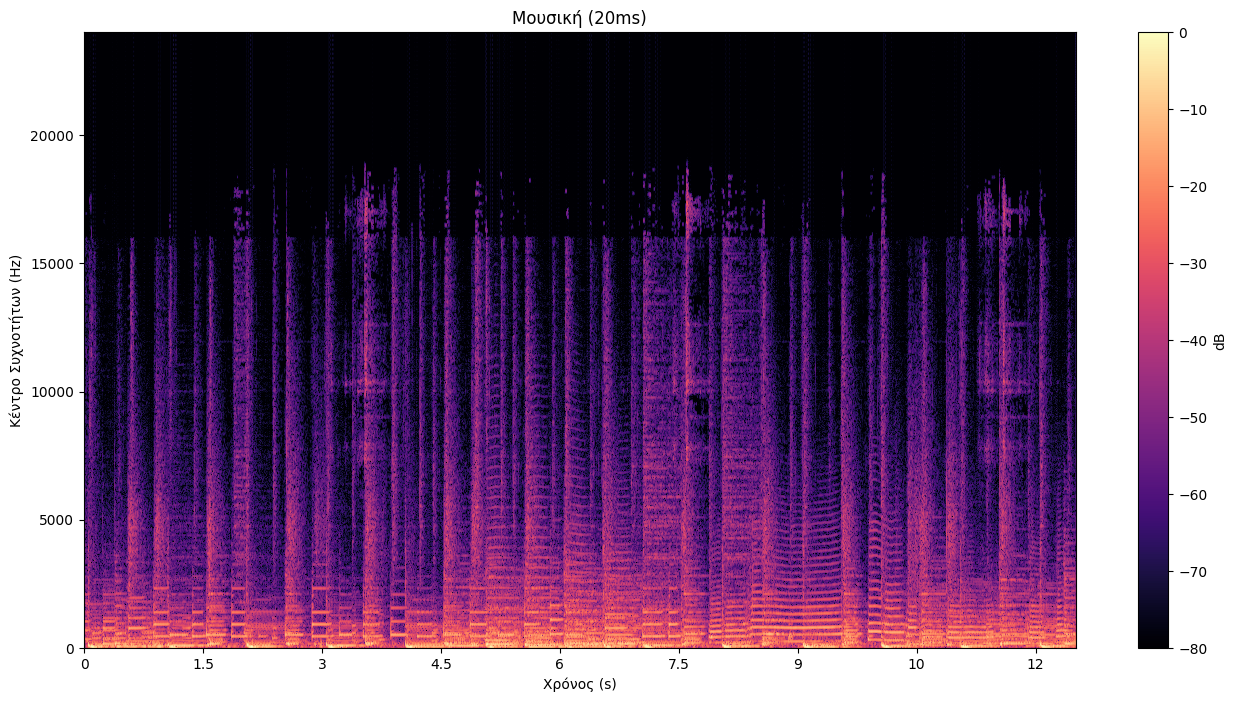

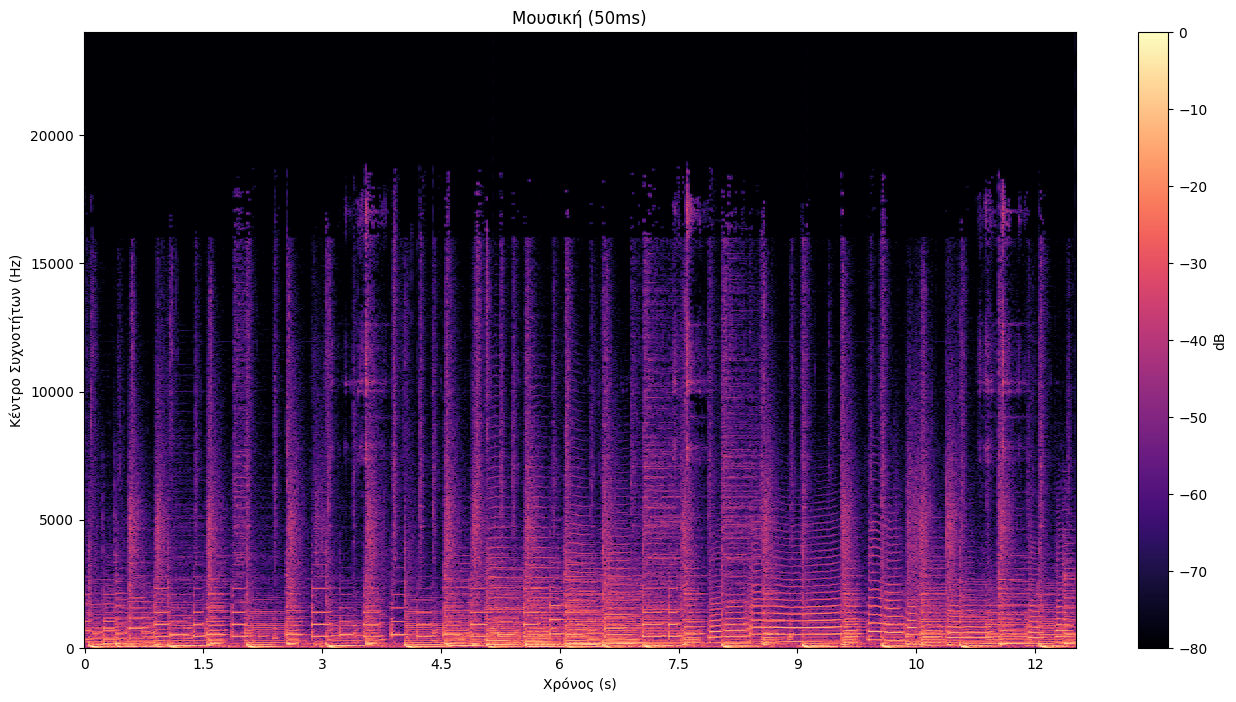

In [29]:
#Με τη χρήση των συναρτήσεων που δημιουργήσαμε νωρίτερα προκύπτει ο stft του σήματος μουσικής

# Υπολογισμός φασματογραμμάτων για music (20ms και 50ms)
spec_music_20, flen_s20, hop_s20 = compute_spectrogram(music, sr_music, 0.02)
spec_music_50, flen_s50, hop_s50 = compute_spectrogram(music, sr_music, 0.05)


#Παρουσίαση για παράθυρα μήκους 20 ms
plt.figure(figsize=(16, 8))
plt.title("Μουσική (20ms)")
librosa.display.specshow(spec_music_20, sr=sr_music, hop_length=hop_s20, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.show()

#Παρουσίαση για παράθυρα μήκους 50 ms
plt.figure(figsize=(16, 8))
plt.title("Μουσική (50ms)")
librosa.display.specshow(spec_music_50, sr=sr_music, hop_length=hop_s50, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.show()

Συμπεράσματα / Παρατηρήσεις: 
* Το φασματογράφημα του μουσικού αποσπάσματος αποτυπώνει την κατανομή ενέργειας στις συχνότητες με την πάροδο του χρόνου.
* Διακρίνονται γραμμές/ζώνες σταθερής συχνότητας που αντιστοιχούν σε αρμονικές των μουσικών νοτών.
* Κρουστά ή απότομες αλλαγές, εμφανίζονται ως σχήματα που εκτείνονται σε πολλές συχνότητες για μικρό χρόνο.

Τελικά, σε σύγκριση με την ομιλία, το μουσικό φάσμα είναι πιο οργανωμένο γύρω από διακριτές νότες και αρμονικές.


#### Υπολογισμός Φασματικού Κέντρου και Ροής

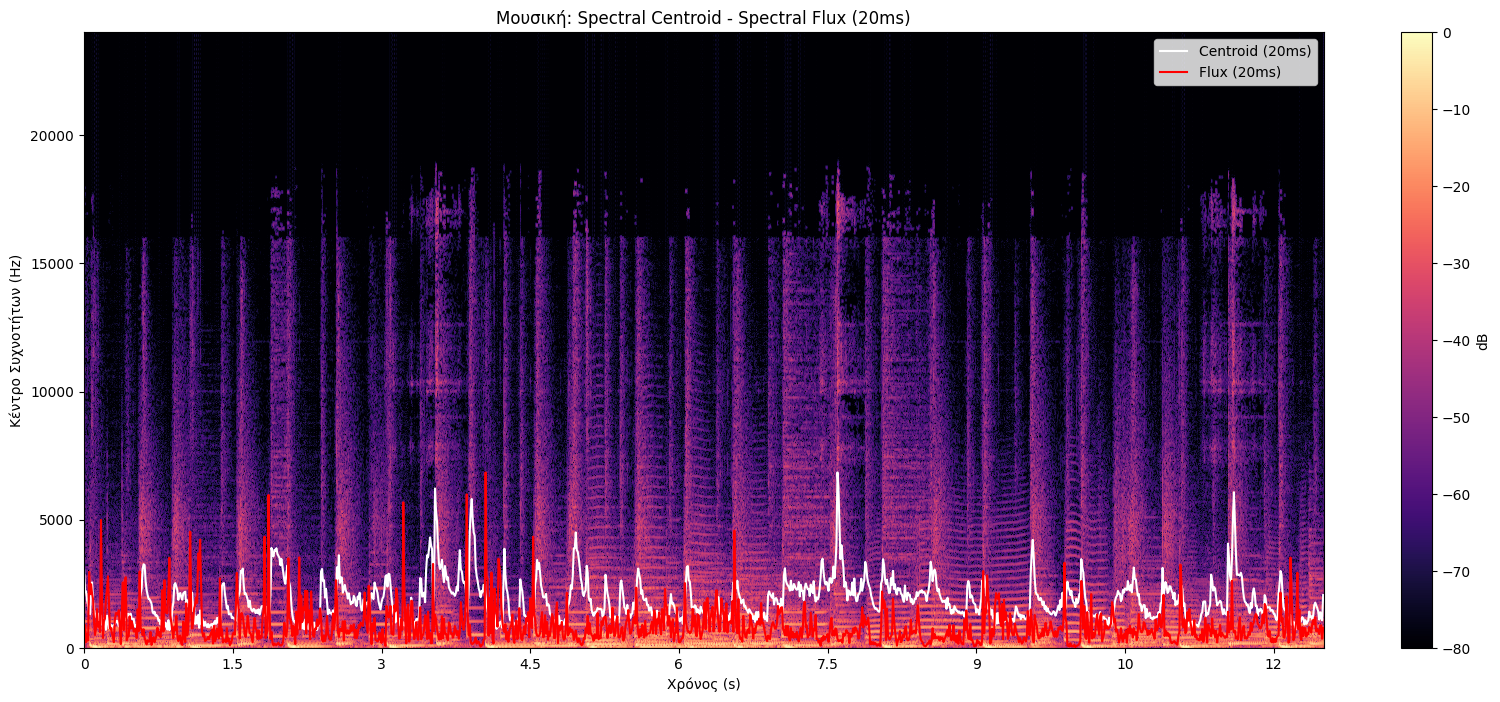

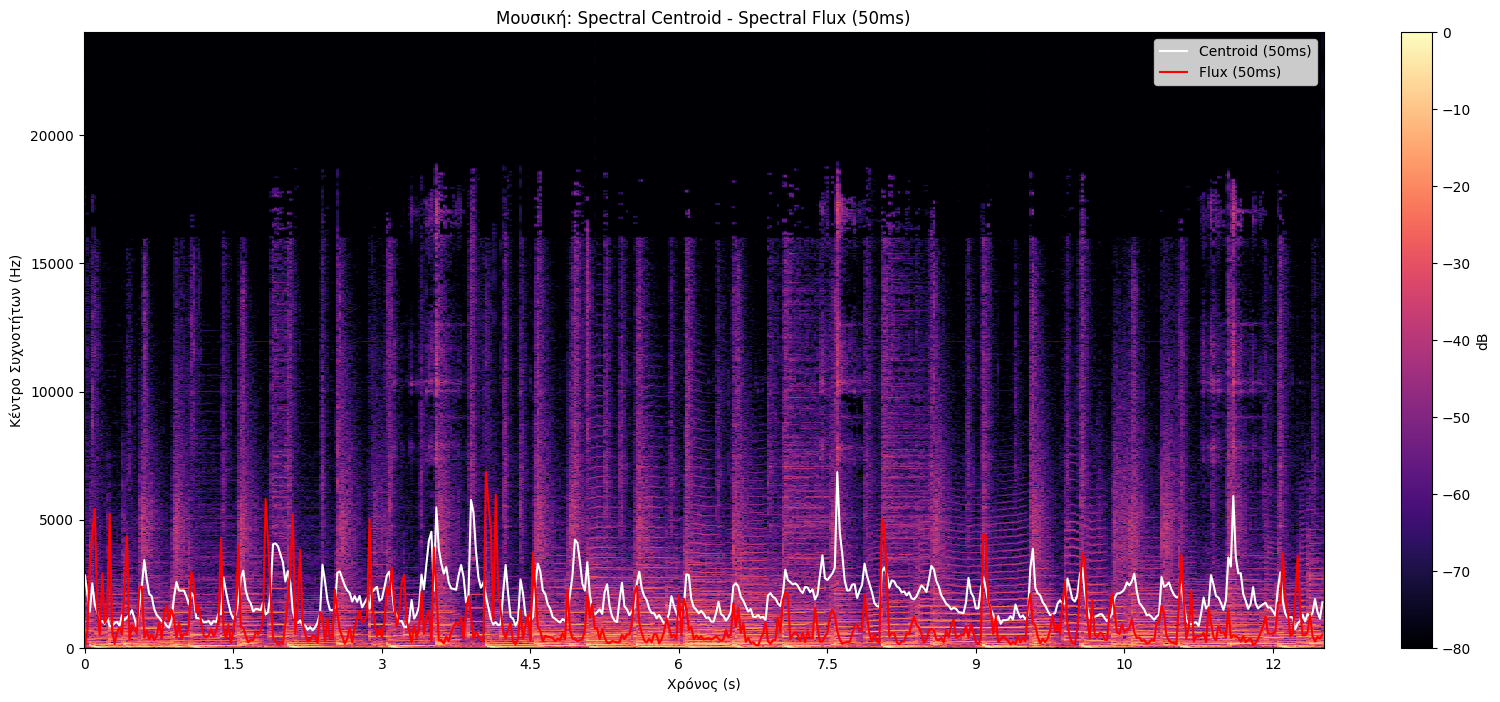

In [30]:
spec_music20, sc_music20, flux_music20, frame_len_20, hop_20 = compute_features(music, sr_music, frame_duration=0.02)
spec_music50, sc_music50, flux_music50, frame_len_50, hop_50 = compute_features(music, sr_music, frame_duration=0.05)

times_music20 = np.arange(sc_music20.shape[0]) * hop_20 / sr_music
times_music50 = np.arange(sc_music50.shape[0]) * hop_50 / sr_music

#Παρουσίαση για παράθυρo μήκους 20 ms
plt.figure(figsize=(20, 8))
plt.title("Μουσική: Spectral Centroid - Spectral Flux (20ms)")
librosa.display.specshow(spec_music_20, sr=sr_music, hop_length=hop_s20, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.plot(times_music20, sc_music20 , label="Centroid (20ms)", color='w')
plt.plot(times_music20, flux_music20 * np.max(sc_music20) / np.max(flux_music20), label="Flux (20ms)", color='r')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.legend(loc='upper right')
plt.show()

#Παρουσίαση για παράθυρo μήκους 50 ms
plt.figure(figsize=(20, 8))
plt.title("Μουσική: Spectral Centroid - Spectral Flux (50ms)")
librosa.display.specshow(spec_music_50, sr=sr_music, hop_length=hop_s50, x_axis='time', y_axis='hz')
plt.colorbar(label ='dB')
plt.plot(times_music50, sc_music50 , label="Centroid (50ms)", color='w')
plt.plot(times_music50, flux_music50 * np.max(sc_music50) / np.max(flux_music50), label="Flux (50ms)", color='r')
plt.xlabel("Χρόνος (s)")
plt.ylabel("Κέντρο Συχνοτήτων (Hz)")
plt.legend(loc='upper right')
plt.show()

Παρατηρήσεις / Συμπεράσματα: 
* Όταν κυριαρχούν χαμηλές νότες ή ήπια όργανα, το κέντρο βάρους είναι χαμηλό (χαμηλές συχνότητες). Όταν εισέρχονται υψηλότερες νότες ή πλούσιες αρμονικές, π.χ. πιάνο σε υψηλή νότα, το φασματικό κέντρο ανεβαίνει, δείχνοντας ότι το ενεργειακό κέντρο του φάσματος μετατοπίζεται προς υψηλότερες συχνότητες.
*  Η φασματική ροή παρουσιάζει κορυφές σε σημεία αλλαγών δηλαδή στην έναρξη νέων νοτών ή ρυθμικών χτύπων. Το μουσικό απόσπασμα είναι πλούσιο σε εναλλαγές νοτών με πολλές αντιθέσεις και ρυθμικούς χτύπους, και αυτό έχει ως αποτέλεσμα να υπάρχουν περιοδικά έντονα σημεία φασματικής ροής και σε άλλα να παραμένει σχετικά σταθερή.

# ΤΕΛΙΚΟ ΣΧΟΛΙΟ
Συνολικά, η ανάλυση αυτή επιβεβαιώνει πώς τα βραχεία στατιστικά χαρακτηριστικά σημάτων μπορούν να χαρακτηρίσουν διαφορετικά είδη ήχων και να παράσχουν πληροφορίες για το περιεχόμενό τους σε ένα χρονικά τοπικό επίπεδο.